In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Deep-learing
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

processed_path = ".processed"
processed_file = os.path.join(processed_path, "household-pow.csv")

In [2]:
df = pd.read_csv(processed_file, header=0, infer_datetime_format=True, parse_dates=["Date_time"], index_col=["Date_time"])
df.sort_values(by=["Date_time"], inplace=True)

In [3]:
df.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667


In [4]:
# Find all columns that have nan:
droping_list_all = []
for j in range(0, 8):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
# Fill nan with mean in any columns
for j in range(0, 8):
    df.iloc[:, j] = df.iloc[:, j].fillna(df.iloc[:, j].mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Sub_metering_4           0
dtype: int64

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
## resampling of data over hour
df_resample = df.resample("h").mean()
df_resample.shape

(34589, 8)

In [8]:
# values = df.values
values = df_resample.values 
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)   
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.813346,0.545045
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560592,0.509006
3,0.509006,0.110073,0.283801,0.502152,0.0,0.030869,0.774169,0.585814,0.488550
4,0.488550,0.096987,0.315988,0.481110,0.0,0.000000,0.778809,0.572244,0.455597
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143,0.322555


In [9]:
values = reframed.values

n_future = 1 * 24  # Number of days we want to look into the future based on the past days.
n_past = 7 * 24  # Number of past days we want to use to predict the future.
n_train_time = 365 * 24

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(n_past, n_train_time - n_future + 1):
    train_X.append(values[i - n_past : i, : values.shape[1] - 1])
    train_y.append(values[i + n_future - 1 : i + n_future, -1])

for i in range(n_train_time - n_future + 1, len(values) - n_future + 1):
    test_X.append(values[i - n_past : i, : values.shape[1] - 1])
    test_y.append(values[i + n_future - 1 : i + n_future, -1])

train_X, train_y = np.array(train_X, dtype=np.float32), np.array(train_y, dtype=np.float32)
test_X, test_y = np.array(test_X, dtype=np.float32), np.array(test_y, dtype=np.float32)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8569, 168, 8) (8569, 1) (25828, 168, 8) (25828, 1)


In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(70), input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [11]:
# fit network
history = model.fit(
    train_X,
    train_y,
    epochs=20,
    batch_size=70,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False,
)

Epoch 1/20
123/123 - 39s - loss: 0.0223 - val_loss: 0.0204 - 39s/epoch - 317ms/step
Epoch 2/20
123/123 - 36s - loss: 0.0195 - val_loss: 0.0199 - 36s/epoch - 294ms/step
Epoch 3/20
123/123 - 37s - loss: 0.0187 - val_loss: 0.0188 - 37s/epoch - 303ms/step
Epoch 4/20
123/123 - 37s - loss: 0.0182 - val_loss: 0.0182 - 37s/epoch - 302ms/step
Epoch 5/20
123/123 - 38s - loss: 0.0180 - val_loss: 0.0179 - 38s/epoch - 312ms/step
Epoch 6/20
123/123 - 38s - loss: 0.0180 - val_loss: 0.0176 - 38s/epoch - 313ms/step
Epoch 7/20
123/123 - 39s - loss: 0.0179 - val_loss: 0.0176 - 39s/epoch - 315ms/step
Epoch 8/20
123/123 - 40s - loss: 0.0178 - val_loss: 0.0175 - 40s/epoch - 326ms/step
Epoch 9/20
123/123 - 40s - loss: 0.0175 - val_loss: 0.0172 - 40s/epoch - 324ms/step
Epoch 10/20
123/123 - 40s - loss: 0.0174 - val_loss: 0.0172 - 40s/epoch - 326ms/step
Epoch 11/20
123/123 - 42s - loss: 0.0171 - val_loss: 0.0171 - 42s/epoch - 345ms/step
Epoch 12/20
123/123 - 41s - loss: 0.0169 - val_loss: 0.0168 - 41s/epoch - 

In [12]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

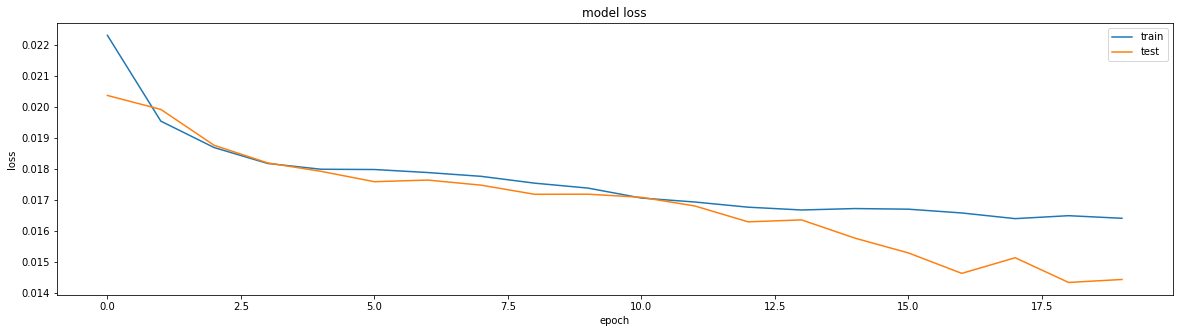

In [13]:
# summarize history for loss
fig = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
# make a prediction
yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
new_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 0, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print("Test RMSE: %.3f" % rmse)

Test RMSE: 0.773


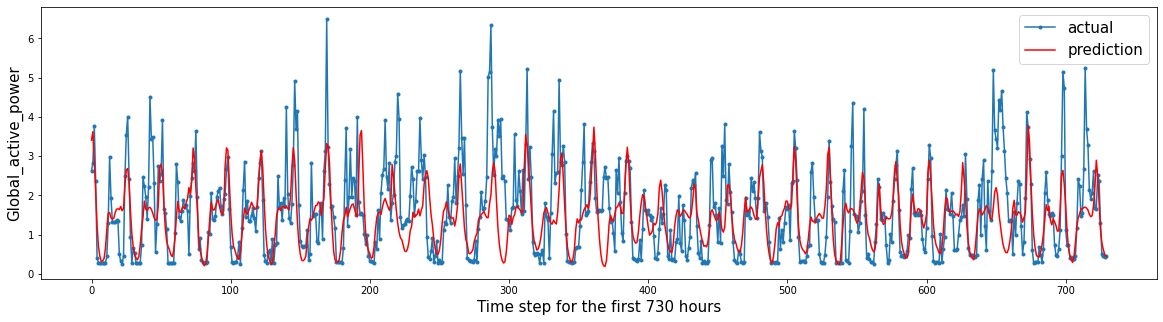

In [15]:
time_val = 730
x_count = [x for x in range(time_val)]
plt.figure(figsize=(20, 5))
plt.plot(x_count, inv_y[:time_val], marker=".", label="actual")
plt.plot(x_count, inv_yhat[:time_val], "r", label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel(f"Time step for the first {time_val} hours", size=15)
plt.legend(fontsize=15)
plt.show()

In [16]:
# serialize the model to disk
# model.save('first_year_hourly.model', save_format="h5")